In [50]:
from typing import List, Tuple, Any, Optional
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [51]:
class Bandit:
    def __init__(
        self, mu: float, sigma: float, with_baseline: bool = True, alpha: float = 0.4
    ):
        self._mu = mu
        self._sigma = sigma
        self._r_baseline = 0
        self._H = 0
        self._alpha = alpha
        self._w_baseline = with_baseline

    def pull(self) -> float:
        return np.random.normal(loc=self._mu, scale=self._sigma)

    def update(self, r: float, soft_val: float, is_selected: bool):
        self._H = (
            self._H + self._alpha * (r - self._r_baseline) * (1 - soft_val)
            if is_selected
            else self._H - self._alpha * (r - self._r_baseline) * (soft_val)
        )

        if self._w_baseline:
            self._r_baseline += (r - self._r_baseline) * self._alpha

    @property
    def preference(self) -> float:
        return self._H

    @property
    def true_val(self) -> float:
        return self._mu

    @preference.setter
    def preference(self, H: float):
        self._H = H

In [52]:
def single_run(bandits: List[Bandit], n_steps: int):

    def calc_softmax(preference: float, preferences: List[float]):
        return np.exp(preference) / np.sum(np.exp(preferences))

    def calc_all_bandits_softmax(bandits: List[Bandit]) -> List[float]:
        res = []
        preferences = [b.preference for b in bandits]
        for b in bandits:
            res.append(calc_softmax(b.preference, preferences))

        return res

    rewards = np.zeros(n_steps)
    optimals = np.zeros(n_steps)

    optimal_bandit = int(np.argmax([b.true_val for b in bandits]))

    for i in range(n_steps):
        probs = calc_all_bandits_softmax(bandits)
        bandit = int(np.random.choice([k for k in range(len(bandits))], p=probs))

        r = bandits[bandit].pull()

        cur_softmax = probs[bandit]
        unselected_bandits = list(set(list(range(len(bandits)))) - {bandit})

        bandits[bandit].update(r, soft_val=cur_softmax, is_selected=True)
        for x in unselected_bandits:
            bandits[x].update(r, probs[x], is_selected=False)

        rewards[i] = r
        optimals[i] = 1 if bandit == optimal_bandit else 0

    return rewards, optimals

In [67]:
def run_experiment(
    true_means: np.ndarray,
    true_sigmas: np.ndarray,
    n_runs: int,
    n_steps: int,
    alpha: float = 0.4,
    with_baseline: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:

    all_rewards = np.zeros((n_runs, n_steps))
    all_optimals = np.zeros((n_runs, n_steps))

    for i in range(n_runs):
        bandits = [
            Bandit(mu=mu, sigma=sigma, with_baseline=with_baseline, alpha=alpha)
            for mu, sigma in zip(true_means, true_sigmas)
        ]
        optimal_bandit = np.argmax([b.true_val for b in bandits])

        rewards, optimals = single_run(bandits=bandits, n_steps=n_steps)
        all_rewards[i] = rewards
        all_optimals[i] = optimals
        # print(f"Optimals: {optimals}")
        if i % 100 == 0:
            print(
                f"Exp - {i}, Optimal bandit: {optimal_bandit}, number of times optimals were selected: {optimals[optimals > 0].size}, with baseline: {with_baseline}, alpha: {alpha}"
            )

    return all_rewards.mean(axis=0), all_optimals.mean(axis=0)

In [68]:
N_STEPS = 1000
N_RUNS = 2000
K = 10
MEANS = np.random.normal(loc=4, scale=1, size=K)
SIGMA = np.ones(K)

In [69]:
exp_r_1, exp_o_1 = run_experiment(
    true_means=MEANS, true_sigmas=SIGMA, n_runs=N_RUNS, n_steps=N_STEPS, alpha=0.4
)
exp_r_2, exp_o_2 = run_experiment(
    true_means=MEANS, true_sigmas=SIGMA, n_runs=N_RUNS, n_steps=N_STEPS, alpha=0.1
)
exp_r_3, exp_o_3 = run_experiment(
    true_means=MEANS,
    true_sigmas=SIGMA,
    n_runs=N_RUNS,
    n_steps=N_STEPS,
    alpha=0.4,
    with_baseline=False,
)
exp_r_4, exp_o_4 = run_experiment(
    true_means=MEANS,
    true_sigmas=SIGMA,
    n_runs=N_RUNS,
    n_steps=N_STEPS,
    alpha=0.1,
    with_baseline=False,
)

Exp - 0, Optimal bandit: 9, number of times optimals were selected: 938, with baseline: True, alpha: 0.4
Exp - 100, Optimal bandit: 9, number of times optimals were selected: 3, with baseline: True, alpha: 0.4
Exp - 200, Optimal bandit: 9, number of times optimals were selected: 1, with baseline: True, alpha: 0.4
Exp - 300, Optimal bandit: 9, number of times optimals were selected: 3, with baseline: True, alpha: 0.4
Exp - 400, Optimal bandit: 9, number of times optimals were selected: 977, with baseline: True, alpha: 0.4
Exp - 500, Optimal bandit: 9, number of times optimals were selected: 4, with baseline: True, alpha: 0.4
Exp - 600, Optimal bandit: 9, number of times optimals were selected: 956, with baseline: True, alpha: 0.4
Exp - 700, Optimal bandit: 9, number of times optimals were selected: 924, with baseline: True, alpha: 0.4
Exp - 800, Optimal bandit: 9, number of times optimals were selected: 0, with baseline: True, alpha: 0.4
Exp - 900, Optimal bandit: 9, number of times opt

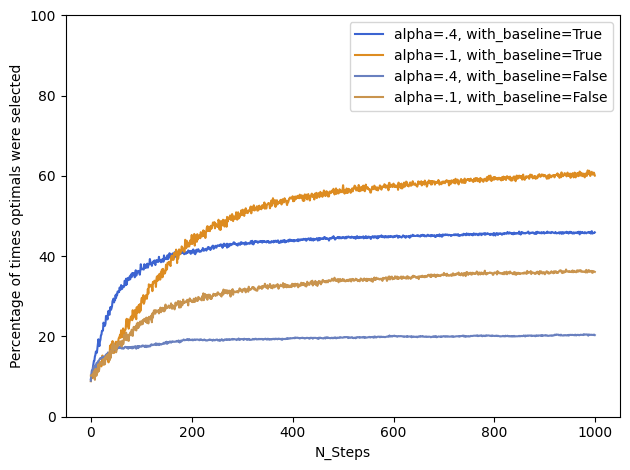

In [72]:
plt.ylim((0, 100))
plt.plot(exp_o_1 * 100, label="alpha=.4, with_baseline=True", color="#3c64d1")
plt.plot(exp_o_2 * 100, label="alpha=.1, with_baseline=True", color="#dd8c21")
plt.plot(exp_o_3 * 100, label="alpha=.4, with_baseline=False", color="#6980bf")
plt.plot(exp_o_4 * 100, label="alpha=.1, with_baseline=False", color="#c9944e")
plt.xlabel("N_Steps")
plt.ylabel("Percentage of times optimals were selected")
plt.legend()
plt.tight_layout()
plt.show()